# Predicción a corto plazo de demanda energía 

En este documento se pretende predecir los consumos eléctricos agregados a corto plazo, para ello se utiliza el algoritmo desarrollado por Alvarez et al. (2021), con la particularidad de que el modelo es entrenado de manera desagregada (en grupo más o menos homogéneos) con el objetivo de aumentar la precisión de la predicción.
Se va utilizar como base de datos de pruebas, un fichero con 400 edificios con sus consumos eléctricos para el año 2013.

### Dejamos cargadas las funciones necesarias para ejecutar el algoritmo de predicción

In [1]:
# [MAPE, RMSE, predictions, load_demand, estimated_errors] = APLF(data, 300, 0.2, 0.7, 24, 48, 3)

def initialize(C, R):
  # initialize parameters
  import numpy as np
  class Theta:
    pass
  class Gamma:
    pass
  a = Theta()
  a.etad = np.zeros((2, C))
  a.sigmad = np.zeros((1, C))
  a.etar = np.zeros((R, C))
  a.sigmar = np.zeros((1, C))
  a.wt = np.zeros((1, C))
  a.sigmat = np.zeros((1, C))
  b = Gamma()
  b.gammat = np.zeros((1, C))
  b.Pt = np.zeros((1, C))
  b.gammad = np.zeros((1, C))
  b.gammar = np.zeros((1, C))
  b.Pd = np.zeros((C, 2, 2))
  b.Pr = np.zeros((C, R, R))
  for i in range(C):
    b.Pd[i] = np.eye(2)
    b.Pr[i] = np.eye(R)
  return a, b

def update_parameters(eta, sigma, P, gamma, l, s, u):
  if np.size(P) > 1:
    if P.trace() > 10:
      P = np.eye(len(P))
    P = (1/l)*(P - (np.dot(np.dot(np.dot(P, u), u.T), P)/(l + np.dot(np.dot(u.T, P),u))))
    gamma = 1 + l*gamma
    sigma = np.sqrt(sigma**2 - (1/gamma)*(sigma**2 - l*(s - np.dot(u.T,eta)[0])**2)/(l + np.dot(np.dot(u.T, P)[0],u)[0]))
    sigma = float(sigma)
    eta = eta + (np.dot(P, u)/(l + np.dot(np.dot(u.T, P)[0],u)[0]))*(s - np.dot(u.T, eta)[0])
  else:
    if P > 10:
      P = 1
    P = (1/l)*(P - (P*u*np.transpose(u)*P)/(l + np.transpose(u)*P*u))
    gamma = 1 + l*gamma
    sigma = np.sqrt(sigma**2 - (1/gamma)*(sigma**2 - l*(s - np.transpose(u)*eta)**2)/(l + np.transpose(u)*P*u))
    eta = eta + (P*u/(l + np.transpose(u)*P*u))*(s - np.transpose(u)*eta)
  return eta, sigma, P, gamma

def test(predictions, load_demand):
  n = len(predictions)
  m = np.zeros(n)
  r = np.zeros(n)
  for i in range(n):
    m[i] = np.abs(predictions[i] - load_demand[i])/load_demand[i]
    r[i] = (predictions[i] - load_demand[i])**2
  MAPE = 100*np.nanmean(m)
  RMSE = np.sqrt(np.nanmean(r))
  return MAPE, RMSE

def update_model(Theta, Gamma, y, x, c, lambdad, lambdar):
  s0 = x[0]
  w = x[1:]
  L = len(y)
  y = [[s0], y[0:]]
  flat_list = []
  for sublist in y:
      for item in sublist:
          flat_list.append(item[0])
  y = flat_list
  for i in range(L):
    [Theta.wt[0][c[i]], Theta.sigmat[0,c[i]], Gamma.Pt[0,c[i]], Gamma.gammat[0,c[i]]] = update_parameters(Theta.wt[0,c[i][0]], Theta.sigmat[0,c[i][0]], Gamma.Pt[0,c[i][0]], Gamma.gammat[0, c[i][0]], 1, w[0][i][0], 1)
    if Theta.wt[0][c[i]] - w[0][i][0] > 20 and (w[0][i][0] > 80 or w[0][i][0] < 20):
      alpha1 = 1
      alpha2 = 0
    elif Theta.wt[0][c[i]] - w[0][i][0] < -20 and (w[0][i][0] > 80 or w[0][i][0] < 20):
      alpha1 = 0
      alpha2 = 1
    else:
      alpha1 = 0
      alpha2 = 0
    ud = np.ones((2, 1))
    ud[1, 0] = y[i]
    [Theta.etad[0:, c[i]], Theta.sigmad[0, c[i][0]], Gamma.Pd[c[i][0]], Gamma.gammad[0, c[i][0]]] = update_parameters(Theta.etad[0:, c[i]], Theta.sigmad[0, c[i][0]], Gamma.Pd[c[i][0]], Gamma.gammad[0, c[i][0]], lambdad, y[i+1], ud)
    ur = np.ones((3, 1))
    ur[1, 0] = alpha1
    ur[2, 0] = alpha2
    [Theta.etar[0:, c[i]], Theta.sigmar[0][c[i]], Gamma.Pr[c[i][0]], Gamma.gammar[0][c[i]]] = update_parameters(Theta.etar[0:, c[i]], Theta.sigmar[0][c[i][0]], Gamma.Pr[c[i][0]], Gamma.gammar[0][c[i][0]], lambdar, y[i+1], ur)
  return Theta, Gamma

def prediction(theta, x, C):
  # prediction function
  L = len(x[1])
  pred_s = np.zeros((L+1, 1))
  e = np.zeros((L+1, 1))
  pred_s[0, 0] = x[0]
  w = x[1:]
  for i in range(L):
    c = C[i]
    ud = [1, pred_s[i, 0]]
    ud = np.transpose(ud)
    if theta.wt[0][c] - w[0][i][0] > 20 and (w[0][i][0] > 80 or w[0][i][0] < 20):
      alpha1 = 1
      alpha2 = 0
    elif theta.wt[0][c] - w[0][i][0] < -20 and (w[0][i][0] > 80 or w[0][i][0] < 20):
      alpha1 = 0
      alpha2 = 1
    else:
      alpha1 = 0
      alpha2 = 0
    ur = np.transpose([1, alpha1, alpha2])
    pred_s[i+1, 0] = (np.dot(np.transpose(ud), theta.etad[0:, c])*theta.sigmar[0][c]**2 + np.dot(np.transpose(ur), theta.etar[0:, c])*(theta.sigmad[0][c]**2 + np.dot(np.dot([0, 1], theta.etad[0:, c])**2, e[i]**2)))/(theta.sigmar[0][c]*theta.sigmar[0][c] + theta.sigmad[0][c]**2 + np.dot((np.dot([0, 1], theta.etad[0:, c])**2),e[i]**2))
    e[i+1, 0] = np.sqrt((theta.sigmar[0][c]**2 * (theta.sigmad[0][c]**2 + np.dot(np.dot([0, 1], theta.etad[0:, c])**2, e[i]**2)))/(theta.sigmar[0][c]**2 + theta.sigmad[0][c]**2 + np.dot(np.dot([0, 1], theta.etad[0:, c])**2, e[i]**2)))
  return pred_s[1:], e[1:]

## 1- Dividimos los edificios en tres grupos según el nivel total de consumo (tomamos como división los cuartiles 1 y 3)

### Cargamos las librerías necesarias

In [2]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, time
import csv
import pandas as pd
from sklearn import metrics
import datetime

### Cargamos la base de datos

In [3]:
#%% Data in .mat file
path = '../Example/'
# os.chdir(path)
filename = 'edificios.mat'
mat = loadmat(path + filename)  # load mat-file
mdata = mat['data']  # variable in mat file
mdtype = mdata.dtype 
data = {n: mdata[n][0, 0] for n in mdtype.names}

### Ajuste con todos los datos

In [4]:
# Prepare df
c = data.get('c')
consumption = data.get('consumption_building')
consumption_m = data.get('consumption')
consumption_t = np.zeros((8760,1))
consumption_t = consumption.sum(axis=1, keepdims = True)

Ejecutar modelo

In [16]:
#%% Execute model
days_train = 20
lambdad = 0.2 # forgetting factor
lambdar = 0.7 # forgetting factor
L = 24 # prediction horizon (hours)
C = 48 # length of the calendar information
R = 3 # length of feature vector of observations
n = len(data.get('consumption'))
# consumption = data.get('consumption')
consumption = data.get('consumption_building')
consumption = np.sum(consumption, axis = 1)
consumption = np.expand_dims(consumption, axis = 1)
ct = data.get('c')
ct = ct - 1
temperature = data.get('temperature')
n_train = 24*days_train
[Theta, Gamma] = initialize(C, R)
predictions = []
estimated_errors = []
load_demand = []
for i in range(0, n_train - L, L):
  s0 = consumption[i]
  w = temperature[i+1:i+L+1]
  x = [s0, w]
  y = consumption[i+1:i+L+1]
  cal = ct[i+1:i+L+1]
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, cal, lambdad, lambdar)
for j in range(i+L+1, n-L, L):
  s0 = consumption[j]
  w = temperature[j+1:j+L+1]
  x = [s0, w]
  [pred_s, e] = prediction(Theta, x, ct[j+1:j+L+1])
  predictions = np.append(predictions, np.transpose(pred_s))
  estimated_errors = np.append(estimated_errors, np.transpose(e))
  y = consumption[j+1:j+L+1]
  load_demand = np.append(load_demand, np.transpose(y))
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, ct[j+1:j+L+1], lambdad, lambdar)
[MAPE, RMSE] = test(predictions, load_demand)
print('MAPE = ', MAPE)
print('RMSE = ', RMSE)

MAPE =  6.658787152554084
RMSE =  17.33841699740209


In [17]:
with open('results/results_aggregated.csv', 'w+') as file:
    writer = csv.writer(file)
    writer.writerow(("predictions", "load demand", "estimated errors"))
    rcount = 0
    for i in range(len(predictions)):
        writer.writerow((predictions[i], load_demand[i], estimated_errors[i]))
        rcount = rcount + 1
    file.close()

Graficamos respecto a la remanda real para ver qué tal se ha hecho la predicción

In [18]:
archivo = 'results/results_aggregated.csv'
datos = pd.read_csv(archivo)

datos['index'] = np.arange(len(datos))
timestamp = np.zeros((8760,1))
timestamp = pd.DataFrame(data.get('timestamp'))
timestamp = timestamp.rename(columns={0:'timestamp'})
timestamp = pd.to_datetime(timestamp['timestamp']-719529,unit='d').round('s')

datos = pd.concat([timestamp, datos], axis = 1)
error_min = datos.apply(lambda x: x['predictions']-x['estimated errors'], axis = 1)
error_max = datos.apply(lambda x: x['predictions']+x['estimated errors'], axis = 1)
datos

,timestamp,predictions,load demand,estimated errors,index
0,2013-01-01 00:00:00,101.908007,94.007,3.215489,0.0
1,2013-01-01 01:00:00,95.998335,96.118,4.799818,1.0
2,2013-01-01 02:00:00,99.054821,97.907,6.576022,2.0
3,2013-01-01 03:00:00,98.479303,103.647,6.923983,3.0
4,2013-01-01 04:00:00,117.312046,116.562,8.195306,4.0
...,...,...,...,...,...
8755,2013-12-31 19:00:00,NaN,NaN,NaN,NaN
8756,2013-12-31 20:00:00,NaN,NaN,NaN,NaN
8757,2013-12-31 21:00:00,NaN,NaN,NaN,NaN
8758,2013-12-31 22:00:00,NaN,NaN,NaN,NaN


/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/5797337.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


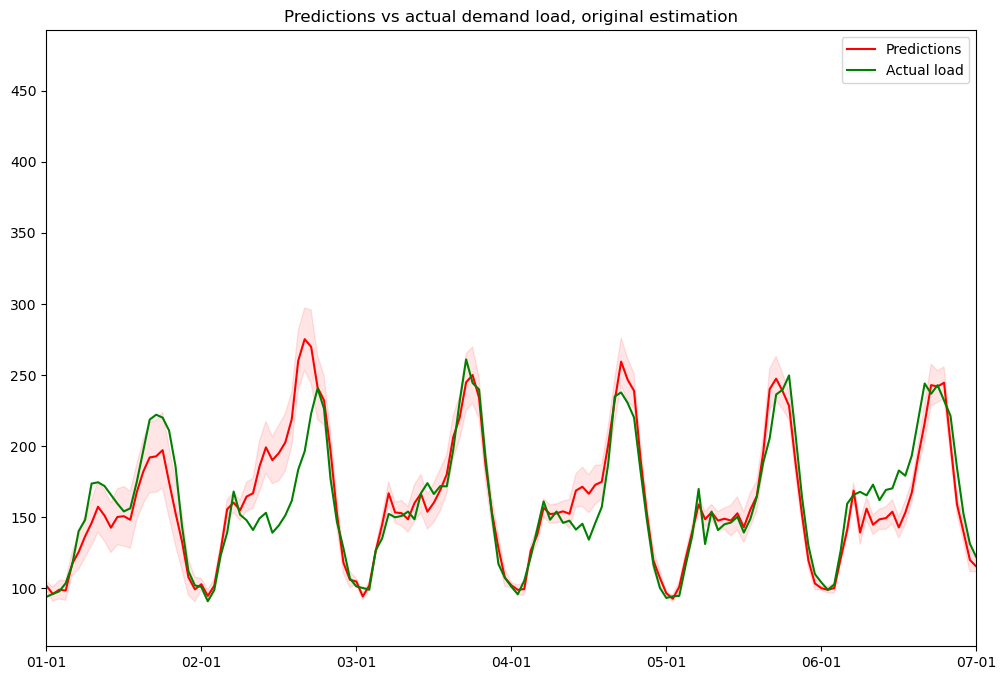

In [47]:
# Datos
x = datos['timestamp']
y1 = datos['predictions']
y2 = datos['load demand']

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.set_title('Predictions vs actual demand load, original estimation')
ax.plot(x, y1, label = 'Predictions', color = 'red')
ax.plot(x, y2, label = 'Actual load', color = 'green')
ax.fill_between(x, error_min, error_max, color = 'red', alpha = 0.1)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m"))   
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax.legend()
fig.show()

### Convertimos el diccionario en dataframe para trabajar con él

In [20]:
c = pd.DataFrame(data.get('c'))
c = c.rename(columns={0:'c'})


temperature = pd.DataFrame(data.get('temperature'))
temperature = temperature.rename(columns={0:'temperature'})

# establecemos el intervalo temporal como indice
timestamp = pd.DataFrame(data.get('timestamp'))
timestamp = timestamp.rename(columns={0:'timestamp'})
timestamp = pd.to_datetime(timestamp['timestamp']-719529,unit='d').round('s')

consumption = data.get('consumption_building')
df = pd.DataFrame(consumption)
#df.columns = [f"build_{c}" for c in df.columns]
df = df.rename(columns={0:'build_1',1:'build_2',2:'build_3',3:'build_4',4:'build_5',5:'build_6',6:'build_7',7:'build_8',8:'build_9',9:'build_10',10:'build_11',11:'build_12',12:'build_13',13:'build_14',14:'build_15',15:'build_16',16:'build_17',17:'build_18',18:'build_19',19:'build_20',20:'build_21',21:'build_22',22:'build_23',23:'build_24',24:'build_25',25:'build_26',26:'build_27',27:'build_28',28:'build_29',29:'build_30',30:'build_31',31:'build_32',32:'build_33',33:'build_34',34:'build_35',35:'build_36',36:'build_37',37:'build_38',38:'build_39',39:'build_40',40:'build_41',41:'build_42',42:'build_43',43:'build_44',44:'build_45',45:'build_46',46:'build_47',47:'build_48',48:'build_49',49:'build_50',50:'build_51',51:'build_52',52:'build_53',53:'build_54',54:'build_55',55:'build_56',56:'build_57',57:'build_58',58:'build_59',59:'build_60',60:'build_61',61:'build_62',62:'build_63',63:'build_64',64:'build_65',65:'build_66',66:'build_67',67:'build_68',68:'build_69',69:'build_70',70:'build_71',71:'build_72',72:'build_73',73:'build_74',74:'build_75',75:'build_76',76:'build_77',77:'build_78',78:'build_79',79:'build_80',80:'build_81',81:'build_82',82:'build_83',83:'build_84',84:'build_85',85:'build_86',86:'build_87',87:'build_88',88:'build_89',89:'build_90',90:'build_91',91:'build_92',92:'build_93',93:'build_94',94:'build_95',95:'build_96',96:'build_97',97:'build_98',98:'build_99',99:'build_100',100:'build_101',101:'build_102',102:'build_103',103:'build_104',104:'build_105',105:'build_106',106:'build_107',107:'build_108',108:'build_109',109:'build_110',110:'build_111',111:'build_112',112:'build_113',113:'build_114',114:'build_115',115:'build_116',116:'build_117',117:'build_118',118:'build_119',119:'build_120',120:'build_121',121:'build_122',122:'build_123',123:'build_124',124:'build_125',125:'build_126',126:'build_127',127:'build_128',128:'build_129',129:'build_130',130:'build_131',131:'build_132',132:'build_133',133:'build_134',134:'build_135',135:'build_136',136:'build_137',137:'build_138',138:'build_139',139:'build_140',140:'build_141',141:'build_142',142:'build_143',143:'build_144',144:'build_145',145:'build_146',146:'build_147',147:'build_148',148:'build_149',149:'build_150',150:'build_151',151:'build_152',152:'build_153',153:'build_154',154:'build_155',155:'build_156',156:'build_157',157:'build_158',158:'build_159',159:'build_160',160:'build_161',161:'build_162',162:'build_163',163:'build_164',164:'build_165',165:'build_166',166:'build_167',167:'build_168',168:'build_169',169:'build_170',170:'build_171',171:'build_172',172:'build_173',173:'build_174',174:'build_175',175:'build_176',176:'build_177',177:'build_178',178:'build_179',179:'build_180',180:'build_181',181:'build_182',182:'build_183',183:'build_184',184:'build_185',185:'build_186',186:'build_187',187:'build_188',188:'build_189',189:'build_190',190:'build_191',191:'build_192',192:'build_193',193:'build_194',194:'build_195',195:'build_196',196:'build_197',197:'build_198',198:'build_199',199:'build_200',200:'build_201',201:'build_202',202:'build_203',203:'build_204',204:'build_205',205:'build_206',206:'build_207',207:'build_208',208:'build_209',209:'build_210',210:'build_211',211:'build_212',212:'build_213',213:'build_214',214:'build_215',215:'build_216',216:'build_217',217:'build_218',218:'build_219',219:'build_220',220:'build_221',221:'build_222',222:'build_223',223:'build_224',224:'build_225',225:'build_226',226:'build_227',227:'build_228',228:'build_229',229:'build_230',230:'build_231',231:'build_232',232:'build_233',233:'build_234',234:'build_235',235:'build_236',236:'build_237',237:'build_238',238:'build_239',239:'build_240',240:'build_241',241:'build_242',242:'build_243',243:'build_244',244:'build_245',245:'build_246',246:'build_247',247:'build_248',248:'build_249',249:'build_250',250:'build_251',251:'build_252',252:'build_253',253:'build_254',254:'build_255',255:'build_256',256:'build_257',257:'build_258',258:'build_259',259:'build_260',260:'build_261',261:'build_262',262:'build_263',263:'build_264',264:'build_265',265:'build_266',266:'build_267',267:'build_268',268:'build_269',269:'build_270',270:'build_271',271:'build_272',272:'build_273',273:'build_274',274:'build_275',275:'build_276',276:'build_277',277:'build_278',278:'build_279',279:'build_280',280:'build_281',281:'build_282',282:'build_283',283:'build_284',284:'build_285',285:'build_286',286:'build_287',287:'build_288',288:'build_289',289:'build_290',290:'build_291',291:'build_292',292:'build_293',293:'build_294',294:'build_295',295:'build_296',296:'build_297',297:'build_298',298:'build_299',299:'build_300',300:'build_301',301:'build_302',302:'build_303',303:'build_304',304:'build_305',305:'build_306',306:'build_307',307:'build_308',308:'build_309',309:'build_310',310:'build_311',311:'build_312',312:'build_313',313:'build_314',314:'build_315',315:'build_316',316:'build_317',317:'build_318',318:'build_319',319:'build_320',320:'build_321',321:'build_322',322:'build_323',323:'build_324',324:'build_325',325:'build_326',326:'build_327',327:'build_328',328:'build_329',329:'build_330',330:'build_331',331:'build_332',332:'build_333',333:'build_334',334:'build_335',335:'build_336',336:'build_337',337:'build_338',338:'build_339',339:'build_340',340:'build_341',341:'build_342',342:'build_343',343:'build_344',344:'build_345',345:'build_346',346:'build_347',347:'build_348',348:'build_349',349:'build_350',350:'build_351',351:'build_352',352:'build_353',353:'build_354',354:'build_355',355:'build_356',356:'build_357',357:'build_358',358:'build_359',359:'build_360',360:'build_361',361:'build_362',362:'build_363',363:'build_364',364:'build_365',365:'build_366',366:'build_367',367:'build_368',368:'build_369',369:'build_370',370:'build_371',371:'build_372',372:'build_373',373:'build_374',374:'build_375',375:'build_376',376:'build_377',377:'build_378',378:'build_379',379:'build_380',380:'build_381',381:'build_382',382:'build_383',383:'build_384',384:'build_385',385:'build_386',386:'build_387',387:'build_388',388:'build_389',389:'build_390',390:'build_391',391:'build_392',392:'build_393',393:'build_394',394:'build_395',395:'build_396',396:'build_397',397:'build_398',398:'build_399',399:'build_400',400:'build_401',401:'build_402',402:'build_403',403:'build_404',404:'build_405',405:'build_406',406:'build_407',407:'build_408',408:'build_409',409:'build_410',410:'build_411',411:'build_412',412:'build_413',413:'build_414',414:'build_415',415:'build_416',416:'build_417',417:'build_418',418:'build_419',419:'build_420',420:'build_421',421:'build_422',422:'build_423',423:'build_424',424:'build_425',425:'build_426',426:'build_427',427:'build_428',428:'build_429',429:'build_430',430:'build_431',431:'build_432',432:'build_433',433:'build_434',434:'build_435',435:'build_436',436:'build_437'}, errors = 'raise')

df1 = pd.concat([timestamp, c, temperature, df], axis = 1)
df1 = df1.set_index('timestamp') 
display(df1)

,c,temperature,build_1,build_2,build_3,build_4,build_5,build_6,build_7,build_8,...,build_428,build_429,build_430,build_431,build_432,build_433,build_434,build_435,build_436,build_437
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1,0,3.629,0.093,0.298,0.241,0.263,0.184,0.191,0.191,...,0.463,0.355,0.100,0.423,0.151,1.100,0.032,0.079,0.081,0.421
2013-01-01 01:00:00,2,0,1.697,0.086,0.163,0.244,0.261,0.183,0.204,0.108,...,0.210,0.395,0.087,0.177,0.129,2.227,0.056,0.071,0.177,0.392
2013-01-01 02:00:00,3,0,1.094,0.083,0.944,0.241,0.260,0.181,0.151,0.105,...,0.134,0.303,0.087,0.207,0.107,0.414,0.032,0.071,0.074,0.347
2013-01-01 03:00:00,4,0,1.363,0.095,0.096,1.034,1.024,0.181,0.046,0.084,...,0.146,0.341,0.085,0.204,0.109,0.415,0.055,0.076,0.069,0.364
2013-01-01 04:00:00,5,0,0.419,0.073,0.097,0.252,0.422,0.181,0.039,0.067,...,0.139,0.185,0.116,0.212,0.117,0.362,0.039,0.064,0.068,0.462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,20,0,2.823,0.218,1.037,0.242,0.319,0.322,0.133,0.248,...,0.278,0.176,0.245,0.170,0.201,0.276,0.042,0.297,0.087,0.403
2013-12-31 20:00:00,21,0,0.485,0.632,1.013,0.248,0.314,0.331,0.038,0.393,...,0.341,0.166,0.613,0.167,0.169,0.220,0.069,0.249,0.087,0.386
2013-12-31 21:00:00,22,0,0.831,0.216,1.677,0.246,0.303,0.315,0.060,0.358,...,0.158,0.217,0.339,0.167,0.246,0.272,0.045,0.233,0.076,0.241


Sacamos los totales por edificio para establecer los umbrales

In [21]:
total = pd.DataFrame(consumption.sum(axis=0))
total.describe()

,0
count,437.000000
mean,3499.111002
std,2597.899439
min,541.954000
25%,2146.222000
50%,3039.131000
75%,4143.522000
max,40512.029000


#### Q1

Dividimos las variables segun quartiles

In [22]:
vars_q1 = df.sum(axis=0) < 2146.22
df_q1 = df.loc[:,vars_q1]
df_q1.to_numpy()

array([[0.191, 0.092, 0.092, ..., 0.032, 0.079, 0.081],
       [0.204, 0.044, 0.072, ..., 0.056, 0.071, 0.177],
       [0.151, 0.043, 0.077, ..., 0.032, 0.071, 0.074],
       ...,
       [0.06 , 0.445, 0.075, ..., 0.045, 0.233, 0.076],
       [0.035, 0.935, 0.084, ..., 0.046, 0.214, 0.07 ],
       [0.585, 0.25 , 0.095, ..., 0.067, 0.135, 0.134]])

Sumamos para hallar el consumo total por intervalo por cada grupo

In [23]:
consumption_q1 = np.sum(df_q1, axis = 1)
consumption_q1 = np.expand_dims(consumption_q1, axis = 1)

Ejecutamos modelo

In [24]:
#%% Execute model
days_train = 20
lambdad = 0.2 # forgetting factor
lambdar = 0.7 # forgetting factor
L = 24 # prediction horizon (hours)
C = 48 # length of the calendar information
R = 3 # length of feature vector of observations
n = len(data.get('consumption'))
# consumption = data.get('consumption')
ct = data.get('c')
ct = ct - 1
temperature = data.get('temperature')
n_train = 24*days_train
[Theta, Gamma] = initialize(C, R)
predictions_q1 = []
estimated_errors_q1 = []
load_demand_q1 = []
for i in range(0, n_train - L, L):
  s0 = consumption_q1[i]
  w = temperature[i+1:i+L+1]
  x = [s0, w]
  y = consumption_q1[i+1:i+L+1]
  cal = ct[i+1:i+L+1]
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, cal, lambdad, lambdar)
for j in range(i+L+1, n-L, L):
  s0 = consumption_q1[j]
  w = temperature[j+1:j+L+1]
  x = [s0, w]
  [pred_s, e] = prediction(Theta, x, ct[j+1:j+L+1])
  predictions_q1 = np.append(predictions_q1, np.transpose(pred_s))
  estimated_errors_q1 = np.append(estimated_errors_q1, np.transpose(e))
  y = consumption_q1[j+1:j+L+1]
  load_demand_q1 = np.append(load_demand_q1, np.transpose(y))
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, ct[j+1:j+L+1], lambdad, lambdar)
[MAPE_q1, RMSE_q1] = test(predictions_q1, load_demand_q1)
print('MAPE = ', MAPE_q1)
print('RMSE = ', RMSE_q1)

MAPE =  10.691263241382694
RMSE =  2.7849940335226813


Guardar resultados

In [25]:
with open('results/results_q1.csv', 'w+') as file:
    writer = csv.writer(file)
    writer.writerow(("predictions", "load demand", "estimated errors"))
    rcount = 0
    for i in range(len(predictions_q1)):
        writer.writerow((predictions_q1[i], load_demand_q1[i], estimated_errors_q1[i]))
        rcount = rcount + 1
    file.close()

Graficamos respecto a la remanda real para ver qué tal se ha hecho la predicción

In [26]:
archivo = 'results/results_q1.csv'
datos_q1 = pd.read_csv(archivo)

datos_q1['index'] = np.arange(len(datos_q1))
timestamp = np.zeros((8760,1))
timestamp = pd.DataFrame(data.get('timestamp'))
timestamp = timestamp.rename(columns={0:'timestamp'})
timestamp = pd.to_datetime(timestamp['timestamp']-719529,unit='d').round('s')

datos_q1 = pd.concat([timestamp, datos_q1], axis = 1)
error_min_q1 = datos_q1.apply(lambda x: x['predictions']-x['estimated errors'], axis = 1)
error_max_q1 = datos_q1.apply(lambda x: x['predictions']+x['estimated errors'], axis = 1)

/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/1775998623.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


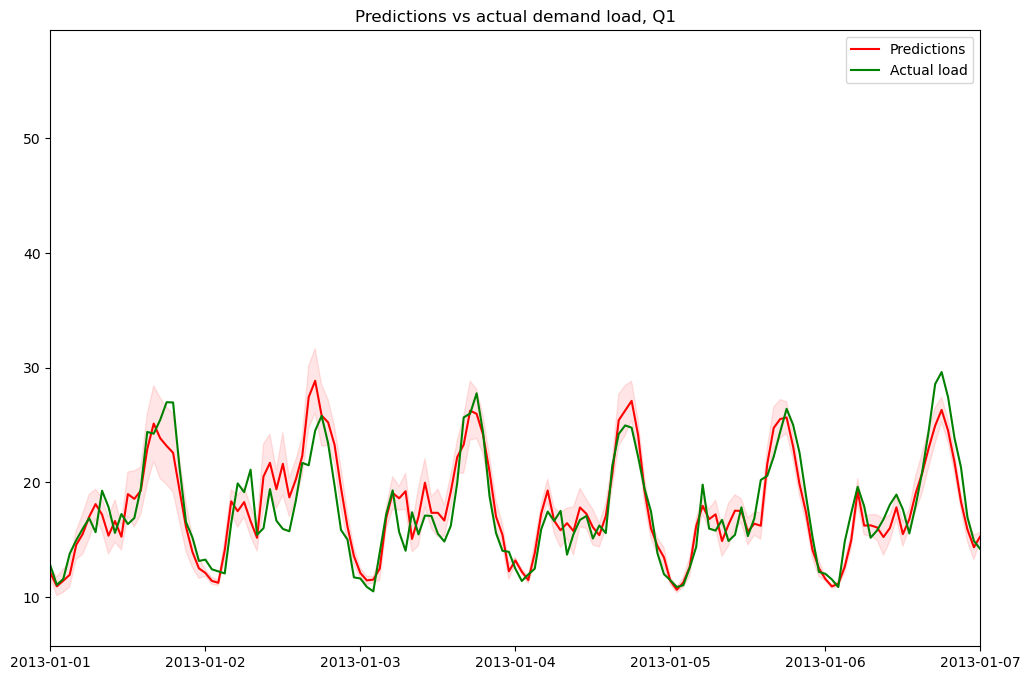

In [27]:
# Datos
x_1 = datos_q1['timestamp']
y1_1 = datos_q1['predictions']
y2_1 = datos_q1['load demand']

fig1, ax = plt.subplots()
fig1.set_size_inches(12, 8)
ax.set_title('Predictions vs actual demand load, Q1')
ax.plot(x_1, y1_1, label = 'Predictions', color = 'red')
ax.plot(x_1, y2_1, label = 'Actual load', color = 'green')
ax.fill_between(x_1, error_min_q1, error_max_q1, color = 'red', alpha = 0.1)
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax.legend()
fig1.show()

#### Q2

Dividimos las variables segun quartiles

In [28]:
vars_q2 = (df.sum(axis=0) > 2146.22) & (df.sum(axis=0) <4143.52)
df_q2 = df.loc[:,vars_q2]
df_q2.to_numpy()

array([[0.191, 0.135, 0.363, ..., 0.151, 1.1  , 0.421],
       [0.108, 0.128, 0.296, ..., 0.129, 2.227, 0.392],
       [0.105, 0.137, 0.24 , ..., 0.107, 0.414, 0.347],
       ...,
       [0.358, 0.215, 0.57 , ..., 0.246, 0.272, 0.241],
       [0.778, 0.161, 0.508, ..., 0.232, 0.402, 0.24 ],
       [0.2  , 0.153, 0.449, ..., 0.312, 0.358, 0.246]])

Sumamos para hallar el consumo total por intervalo por cada grupo

In [29]:
consumption_q2 = np.sum(df_q2, axis = 1)
consumption_q2 = np.expand_dims(consumption_q2, axis = 1)

Ejecutamos modelo

In [30]:
#%% Execute model
days_train = 20
lambdad = 0.2 # forgetting factor
lambdar = 0.7 # forgetting factor
L = 24 # prediction horizon (hours)
C = 48 # length of the calendar information
R = 3 # length of feature vector of observations
n = len(data.get('consumption'))
# consumption = data.get('consumption')
ct = data.get('c')
ct = ct - 1
temperature = data.get('temperature')
n_train = 24*days_train
[Theta, Gamma] = initialize(C, R)
predictions_q2 = []
estimated_errors_q2 = []
load_demand_q2 = []
for i in range(0, n_train - L, L):
  s0 = consumption_q2[i]
  w = temperature[i+1:i+L+1]
  x = [s0, w]
  y = consumption_q2[i+1:i+L+1]
  cal = ct[i+1:i+L+1]
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, cal, lambdad, lambdar)
for j in range(i+L+1, n-L, L):
  s0 = consumption_q2[j]
  w = temperature[j+1:j+L+1]
  x = [s0, w]
  [pred_s, e] = prediction(Theta, x, ct[j+1:j+L+1])
  predictions_q2 = np.append(predictions_q2, np.transpose(pred_s))
  estimated_errors_q2 = np.append(estimated_errors_q2, np.transpose(e))
  y = consumption_q2[j+1:j+L+1]
  load_demand_q2 = np.append(load_demand_q2, np.transpose(y))
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, ct[j+1:j+L+1], lambdad, lambdar)
[MAPE_q2, RMSE_q2] = test(predictions_q2, load_demand_q2)
print('MAPE = ', MAPE_q2)
print('RMSE = ', RMSE_q2)

MAPE =  8.133576337984765
RMSE =  8.777286926348454


Guardar resultados

In [31]:
with open('results/results_q2.csv', 'w+') as file:
    writer = csv.writer(file)
    writer.writerow(("predictions", "load demand", "estimated errors"))
    rcount = 0
    for i in range(len(predictions_q2)):
        writer.writerow((predictions_q2[i], load_demand_q2[i], estimated_errors_q2[i]))
        rcount = rcount + 1
    file.close()

Graficamos respecto a la remanda real para ver qué tal se ha hecho la predicción

In [32]:
archivo = 'results/results_q2.csv'
datos_q2 = pd.read_csv(archivo)

datos_q2['index'] = np.arange(len(datos_q2))
timestamp = np.zeros((8760,1))
timestamp = pd.DataFrame(data.get('timestamp'))
timestamp = timestamp.rename(columns={0:'timestamp'})
timestamp = pd.to_datetime(timestamp['timestamp']-719529,unit='d').round('s')

datos_q2 = pd.concat([timestamp, datos_q2], axis = 1)
error_min_q2 = datos_q2.apply(lambda x: x['predictions']-x['estimated errors'], axis = 1)
error_max_q2 = datos_q2.apply(lambda x: x['predictions']+x['estimated errors'], axis = 1)

/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/2939972916.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


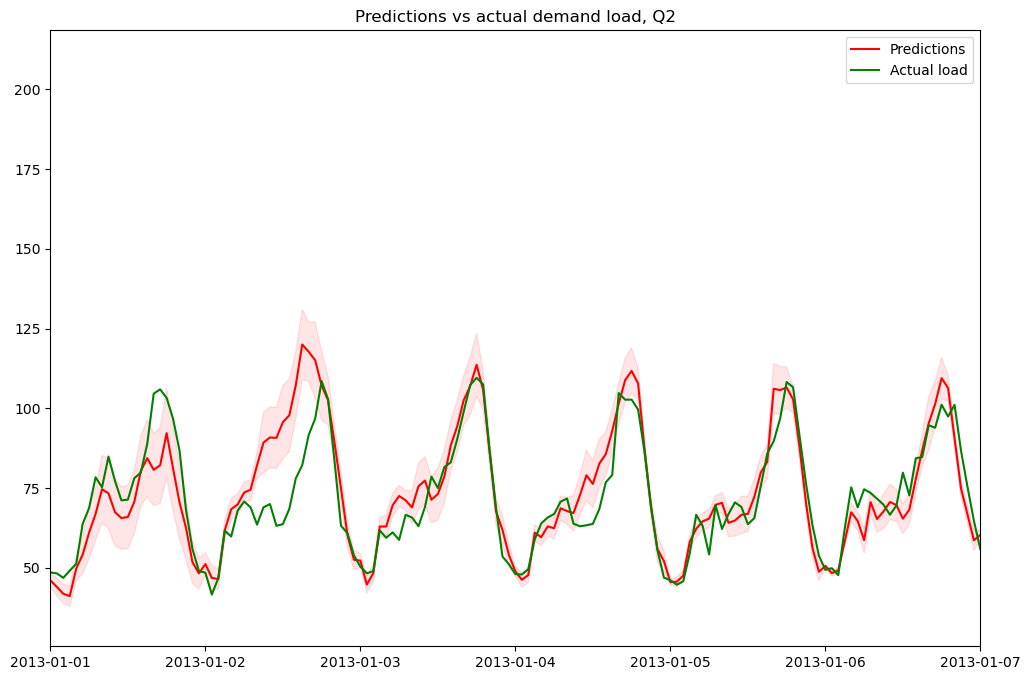

In [33]:
# Datos
x_2 = datos_q2['timestamp']
y1_2 = datos_q2['predictions']
y2_2 = datos_q2['load demand']

fig2, ax = plt.subplots()
fig2.set_size_inches(12, 8)
ax.set_title('Predictions vs actual demand load, Q2')
ax.plot(x_2, y1_2, label = 'Predictions', color = 'red')
ax.plot(x_2, y2_2, label = 'Actual load', color = 'green')
ax.fill_between(x_2, error_min_q2, error_max_q2, color = 'red', alpha = 0.1)
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax.legend()
fig2.show()

#### Q3

In [34]:
vars_q3 = df.sum(axis=0) > 4143.52
df_q3 = df.loc[:,vars_q3]
df_q3.to_numpy()

array([[3.629, 0.093, 0.298, ..., 0.669, 0.163, 0.367],
       [1.697, 0.086, 0.163, ..., 0.586, 0.192, 0.305],
       [1.094, 0.083, 0.944, ..., 0.565, 0.182, 0.431],
       ...,
       [0.831, 0.216, 1.677, ..., 0.513, 0.18 , 0.78 ],
       [0.173, 0.214, 0.128, ..., 0.519, 0.167, 0.571],
       [0.167, 0.216, 0.099, ..., 0.491, 0.165, 0.353]])

In [35]:
consumption_q3 = np.sum(df_q3, axis = 1)
consumption_q3 = np.expand_dims(consumption_q3, axis = 1)

In [36]:
#%% Execute model
days_train = 20
lambdad = 0.2 # forgetting factor
lambdar = 0.7 # forgetting factor
L = 24 # prediction horizon (hours)
C = 48 # length of the calendar information
R = 3 # length of feature vector of observations
n = len(data.get('consumption'))
# consumption = data.get('consumption')
ct = data.get('c')
ct = ct - 1
temperature = data.get('temperature')
n_train = 24*days_train
[Theta, Gamma] = initialize(C, R)
predictions_q3 = []
estimated_errors_q3 = []
load_demand_q3 = []
for i in range(0, n_train - L, L):
  s0 = consumption_q3[i]
  w = temperature[i+1:i+L+1]
  x = [s0, w]
  y = consumption_q3[i+1:i+L+1]
  cal = ct[i+1:i+L+1]
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, cal, lambdad, lambdar)
for j in range(i+L+1, n-L, L):
  s0 = consumption_q3[j]
  w = temperature[j+1:j+L+1]
  x = [s0, w]
  [pred_s, e] = prediction(Theta, x, ct[j+1:j+L+1])
  predictions_q3 = np.append(predictions_q3, np.transpose(pred_s))
  estimated_errors_q3 = np.append(estimated_errors_q3, np.transpose(e))
  y = consumption_q3[j+1:j+L+1]
  load_demand_q3 = np.append(load_demand_q3, np.transpose(y))
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, ct[j+1:j+L+1], lambdad, lambdar)
[MAPE_q3, RMSE_q3] = test(predictions_q3, load_demand_q3)
print('MAPE = ', MAPE_q3)
print('RMSE = ', RMSE_q3)

MAPE =  9.151697781942971
RMSE =  10.049396510286794


In [37]:
with open('results/results_q3.csv', 'w+') as file:
    writer = csv.writer(file)
    writer.writerow(("predictions", "load demand", "estimated errors"))
    rcount = 0
    for i in range(len(predictions_q3)):
        writer.writerow((predictions_q3[i], load_demand_q3[i], estimated_errors_q3[i]))
        rcount = rcount + 1
    file.close()

In [38]:
archivo = 'results/results_q3.csv'
datos_q3 = pd.read_csv(archivo)

datos_q3['index'] = np.arange(len(datos_q3))
timestamp = np.zeros((8760,1))
timestamp = pd.DataFrame(data.get('timestamp'))
timestamp = timestamp.rename(columns={0:'timestamp'})
timestamp = pd.to_datetime(timestamp['timestamp']-719529,unit='d').round('s')

datos_q3 = pd.concat([timestamp, datos_q3], axis = 1)
error_min_q3 = datos_q3.apply(lambda x: x['predictions']-x['estimated errors'], axis = 1)
error_max_q3 = datos_q3.apply(lambda x: x['predictions']+x['estimated errors'], axis = 1)

/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/6916965.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


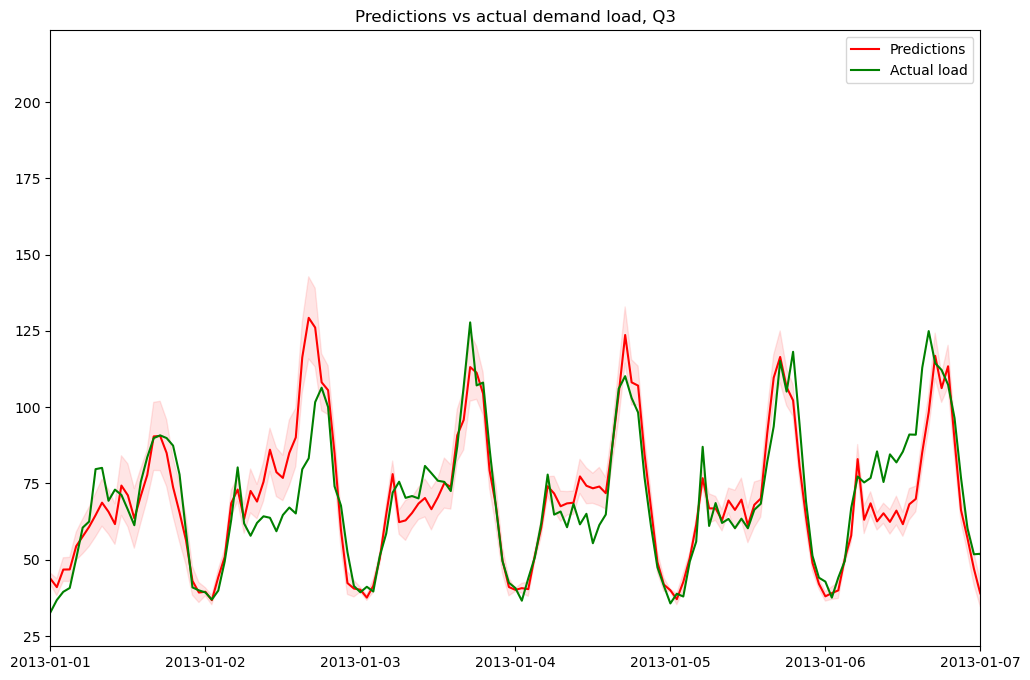

In [39]:
# Datos
x_3 = datos_q3['timestamp']
y1_3 = datos_q3['predictions']
y2_3 = datos_q3['load demand']

fig2, ax = plt.subplots()
fig2.set_size_inches(12, 8)
ax.set_title('Predictions vs actual demand load, Q3')
ax.plot(x_3, y1_3, label = 'Predictions', color = 'red')
ax.plot(x_3, y2_3, label = 'Actual load', color = 'green')
ax.fill_between(x_3, error_min_q3, error_max_q3, color = 'red', alpha = 0.1)
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax.legend()
fig2.show()

### Creamos DF para almacenar los errores

In [40]:
method = ['Gen', 'Q1', 'Q2', 'Q3']
RMSE_v = [RMSE, RMSE_q1, RMSE_q2, RMSE_q3]
MAPE_v = [MAPE, MAPE_q1, MAPE_q2, MAPE_q3]

errors = pd.DataFrame()
errors['Method'] = method
errors['RMSE'] = RMSE_v
errors['MAPE'] = MAPE_v
errors

,Method,RMSE,MAPE
0,Gen,17.338417,6.658787
1,Q1,2.784994,10.691263
2,Q2,8.777287,8.133576
3,Q3,10.049397,9.151698


Obtenemos la predicción agregada sumando las predicciones por cuartiles y calculamos errores

In [41]:
predictions_agg = predictions_q1+predictions_q2+predictions_q3
load_demand_agg = load_demand_q1+load_demand_q2+load_demand_q3
[MAPE_agg, RMSE_agg] = test(predictions_agg, load_demand_agg)
print('MAPE =', MAPE_agg)
print('RMSE =', RMSE_agg)

new_row = pd.Series(['Agg', RMSE_agg, MAPE_agg], index=errors.columns) # creamos un objeto Seris
errors = errors.append(new_row, ignore_index=True)
errors = errors.sort_values('MAPE')
errors

MAPE = 6.669640195118522
RMSE = 17.32881889440709


/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/1793499813.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append(new_row, ignore_index=True)


,Method,RMSE,MAPE
0,Gen,17.338417,6.658787
4,Agg,17.328819,6.669640
2,Q2,8.777287,8.133576
3,Q3,10.049397,9.151698
1,Q1,2.784994,10.691263


/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/1333120016.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_agg.show()


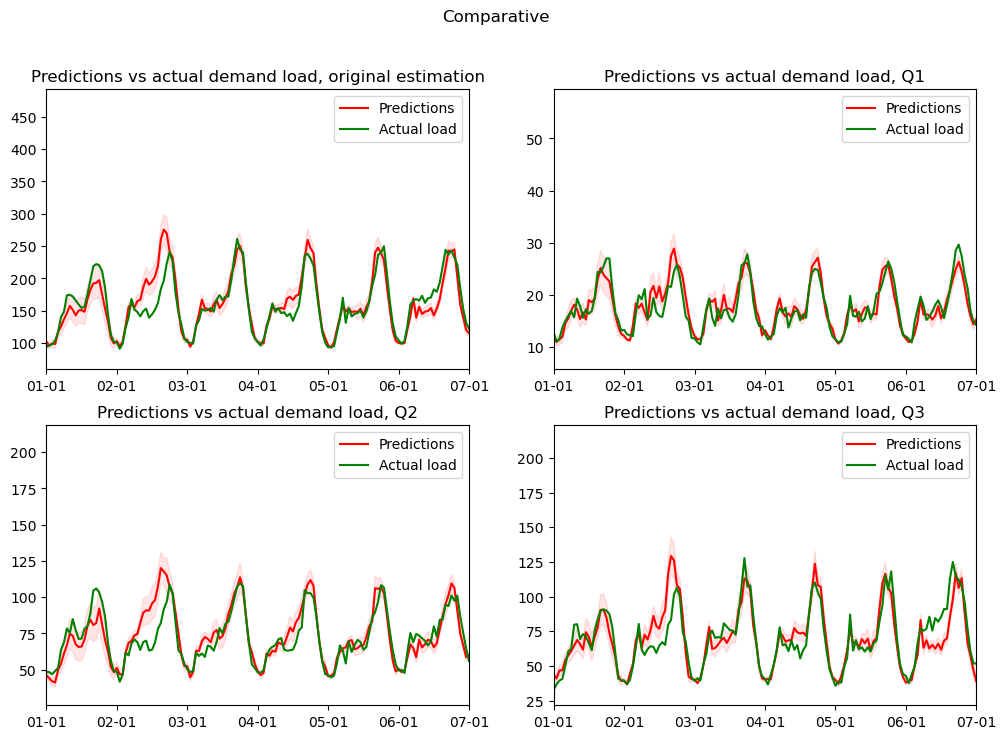

In [66]:
fig_agg, ((ax, ax1), (ax2, ax3)) = plt.subplots(2,2)
fig_agg.suptitle('Comparative')
fig_agg.set_size_inches(12, 8)

# Original
ax.set_title('Predictions vs actual demand load, original estimation')
ax.plot(x, y1, label = 'Predictions', color = 'red')
ax.plot(x, y2, label = 'Actual load', color = 'green')
ax.fill_between(x, error_min, error_max, color = 'red', alpha = 0.1)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m"))   
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax.legend()

# Q1
ax1.set_title('Predictions vs actual demand load, Q1')
ax1.plot(x_1, y1_1, label = 'Predictions', color = 'red')
ax1.plot(x_1, y2_1, label = 'Actual load', color = 'green')
ax1.fill_between(x_1, error_min_q1, error_max_q1, color = 'red', alpha = 0.1)
ax1.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m"))  
ax1.legend()
# Q2
ax2.set_title('Predictions vs actual demand load, Q2')
ax2.plot(x_2, y1_2, label = 'Predictions', color = 'red')
ax2.plot(x_2, y2_2, label = 'Actual load', color = 'green')
ax2.fill_between(x_2, error_min_q2, error_max_q2, color = 'red', alpha = 0.1)
ax2.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m"))  
ax2.legend()
# Q3
ax3.set_title('Predictions vs actual demand load, Q3')
ax3.plot(x_3, y1_3, label = 'Predictions', color = 'red')
ax3.plot(x_3, y2_3, label = 'Actual load', color = 'green')
ax3.fill_between(x_3, error_min_q3, error_max_q3, color = 'red', alpha = 0.1)
ax3.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m"))  
ax3.legend()

fig_agg.show()

/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/1641124732.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_day.show()


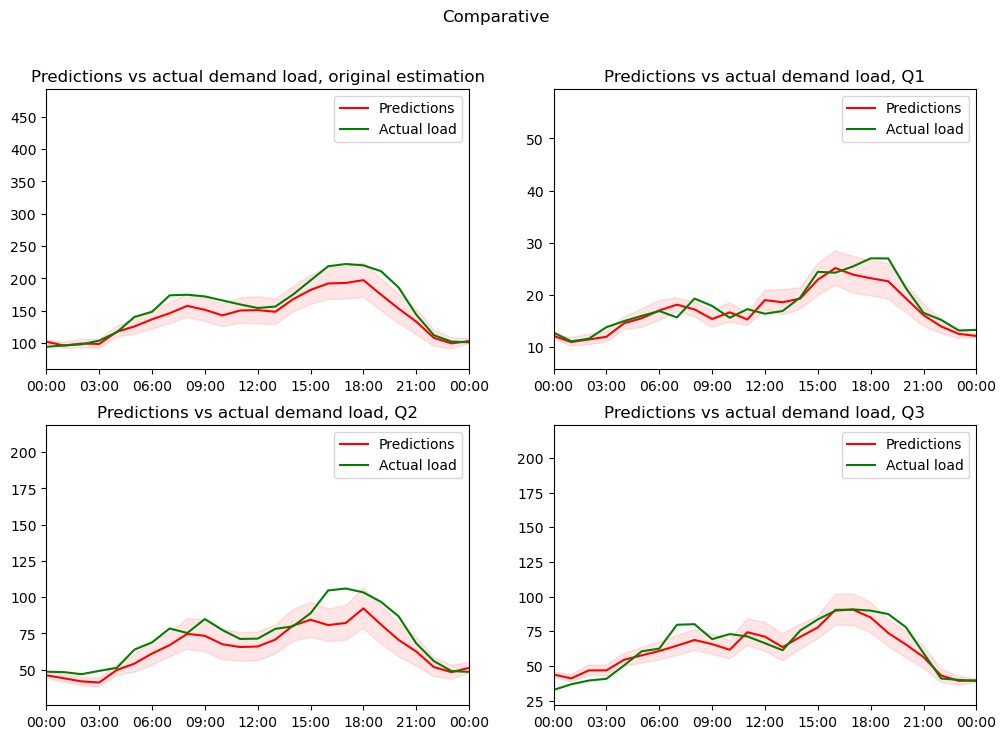

In [65]:
fig_day, ((ax, ax1), (ax2, ax3)) = plt.subplots(2,2)
fig_day.suptitle('Comparative')
fig_day.set_size_inches(12, 8)

# Original
ax.set_title('Predictions vs actual demand load, original estimation')
ax.plot(x, y1, label = 'Predictions', color = 'red')
ax.plot(x, y2, label = 'Actual load', color = 'green')
ax.fill_between(x, error_min, error_max, color = 'red', alpha = 0.1)
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 2)])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))   
ax.legend()

# Q1
ax1.set_title('Predictions vs actual demand load, Q1')
ax1.plot(x_1, y1_1, label = 'Predictions', color = 'red')
ax1.plot(x_1, y2_1, label = 'Actual load', color = 'green')
ax1.fill_between(x_1, error_min_q1, error_max_q1, color = 'red', alpha = 0.1)
ax1.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 2)])
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))  
ax1.legend()
# Q2
ax2.set_title('Predictions vs actual demand load, Q2')
ax2.plot(x_2, y1_2, label = 'Predictions', color = 'red')
ax2.plot(x_2, y2_2, label = 'Actual load', color = 'green')
ax2.fill_between(x_2, error_min_q2, error_max_q2, color = 'red', alpha = 0.1)
ax2.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 2)])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))  
ax2.legend()
# Q3
ax3.set_title('Predictions vs actual demand load, Q3')
ax3.plot(x_3, y1_3, label = 'Predictions', color = 'red')
ax3.plot(x_3, y2_3, label = 'Actual load', color = 'green')
ax3.fill_between(x_3, error_min_q3, error_max_q3, color = 'red', alpha = 0.1)
ax3.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 2)])
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))  
ax3.legend()

fig_day.show()

In [50]:
with open('results/results_agg.csv', 'w+') as file:
    writer = csv.writer(file)
    writer.writerow(("predictions", "load demand"))
    rcount = 0
    for i in range(len(predictions_agg)):
        writer.writerow((predictions_agg[i], load_demand_agg[i]))
        rcount = rcount + 1
    file.close()

Cargamos lo datos y graficamos los resultados de la estimación agregando las estimaciones por quartiles

In [64]:
archivo = 'results/results_agg.csv'
datos_agg = pd.read_csv(archivo)

datos_agg['index'] = np.arange(len(datos_agg))
timestamp = np.zeros((8760,1))
timestamp = pd.DataFrame(data.get('timestamp'))
timestamp = timestamp.rename(columns={0:'timestamp'})
timestamp = pd.to_datetime(timestamp['timestamp']-719529,unit='d').round('s')

datos_agg = pd.concat([timestamp, datos_agg], axis = 1)

/var/folders/sw/xrgdsp691gg7tb56v4cn4fp00000gp/T/ipykernel_4054/1804376288.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_gen.show()


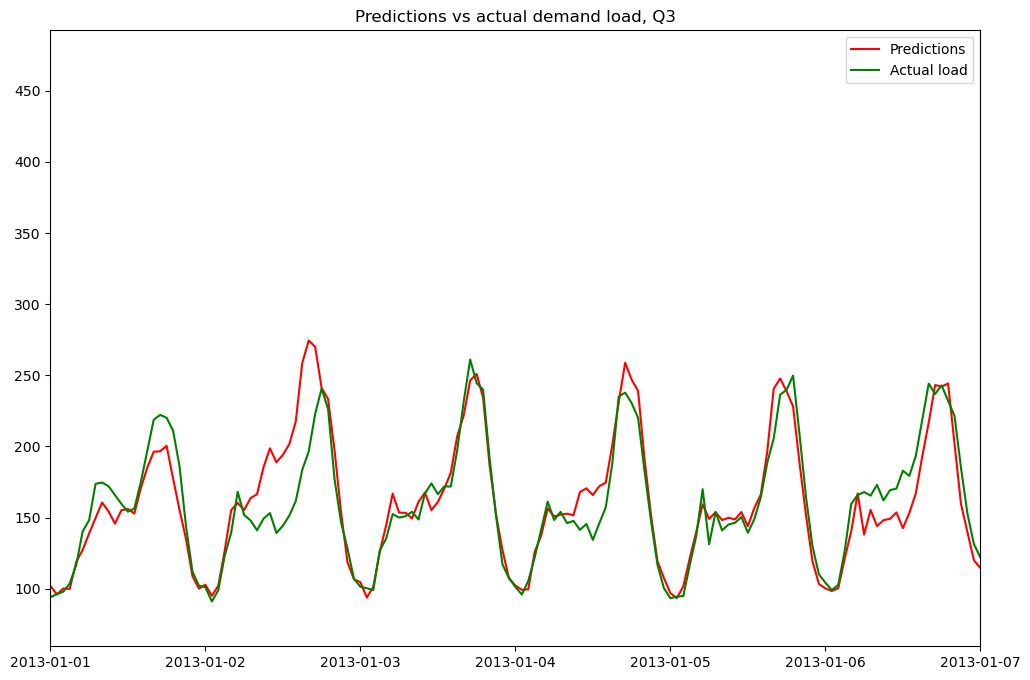

In [52]:
# Datos
x_agg = datos_agg['timestamp']
y1_agg = datos_agg['predictions']
y2_agg = datos_agg['load demand']

fig_gen, ax = plt.subplots()
fig_gen.set_size_inches(12, 8)
ax.set_title('Predictions vs actual demand load, Q3')
ax.plot(x_agg, y1_agg, label = 'Predictions', color = 'red')
ax.plot(x_agg, y2_agg, label = 'Actual load', color = 'green')
#ax.fill_between(x_agg, error_min_q3, error_max_q3, color = 'red', alpha = 0.1)
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2013, 1, 7)])
ax.legend()
fig_gen.show()

In [1]:
# [MAPE, RMSE, predictions, load_demand, estimated_errors] = APLF(data, 300, 0.2, 0.7, 24, 48, 3)

def initialize(C, R):
  # initialize parameters
  import numpy as np
  class Theta:
    pass
  class Gamma:
    pass
  a = Theta()
  a.etad = np.zeros((2, C))
  a.sigmad = np.zeros((1, C))
  a.etar = np.zeros((R, C))
  a.sigmar = np.zeros((1, C))
  a.wt = np.zeros((1, C))
  a.sigmat = np.zeros((1, C))
  b = Gamma()
  b.gammat = np.zeros((1, C))
  b.Pt = np.zeros((1, C))
  b.gammad = np.zeros((1, C))
  b.gammar = np.zeros((1, C))
  b.Pd = np.zeros((C, 2, 2))
  b.Pr = np.zeros((C, R, R))
  for i in range(C):
    b.Pd[i] = np.eye(2)
    b.Pr[i] = np.eye(R)
  return a, b

def prediction(theta, x, C):
  # prediction function
  L = len(x[1])
  pred_s = np.zeros((L+1, 1))
  e = np.zeros((L+1, 1))
  pred_s[0, 0] = x[0]
  w = x[1:]
  for i in range(L):
    c = C[i]
    ud = [1, pred_s[i, 0]]
    ud = np.transpose(ud)
    if theta.wt[0][c] - w[0][i][0] > 20 and (w[0][i][0] > 80 or w[0][i][0] < 20):
      alpha1 = 1
      alpha2 = 0
    elif theta.wt[0][c] - w[0][i][0] < -20 and (w[0][i][0] > 80 or w[0][i][0] < 20):
      alpha1 = 0
      alpha2 = 1
    else:
      alpha1 = 0
      alpha2 = 0
    ur = np.transpose([1, alpha1, alpha2])
    pred_s[i+1, 0] = (np.dot(np.transpose(ud), theta.etad[0:, c])*theta.sigmar[0][c]**2 + np.dot(np.transpose(ur), theta.etar[0:, c])*(theta.sigmad[0][c]**2 + np.dot(np.dot([0, 1], theta.etad[0:, c])**2, e[i]**2)))/(theta.sigmar[0][c]*theta.sigmar[0][c] + theta.sigmad[0][c]**2 + np.dot((np.dot([0, 1], theta.etad[0:, c])**2),e[i]**2))
    e[i+1, 0] = np.sqrt((theta.sigmar[0][c]**2 * (theta.sigmad[0][c]**2 + np.dot(np.dot([0, 1], theta.etad[0:, c])**2, e[i]**2)))/(theta.sigmar[0][c]**2 + theta.sigmad[0][c]**2 + np.dot(np.dot([0, 1], theta.etad[0:, c])**2, e[i]**2)))
  return pred_s[1:], e[1:]

In [36]:
#%% Execute model
days_train = 20
lambdad = 0.2 # forgetting factor
lambdar = 0.7 # forgetting factor
L = 24 # prediction horizon (hours)
C = 48 # length of the calendar information
R = 3 # length of feature vector of observations
n = len(data.get('consumption'))
# consumption = data.get('consumption')
ct = data.get('c')
ct = ct - 1
temperature = data.get('temperature')
n_train = 24*days_train
[Theta, Gamma] = initialize(C, R)
predictions_q3 = []
estimated_errors_q3 = []
load_demand_q3 = []
for i in range(0, n_train - L, L):
  s0 = consumption_q3[i]
  w = temperature[i+1:i+L+1]
  x = [s0, w]
  y = consumption_q3[i+1:i+L+1]
  cal = ct[i+1:i+L+1]
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, cal, lambdad, lambdar)
for j in range(i+L+1, n-L, L):
  s0 = consumption_q3[j]
  w = temperature[j+1:j+L+1]
  x = [s0, w]
  [pred_s, e] = prediction(Theta, x, ct[j+1:j+L+1])
  predictions_q3 = np.append(predictions_q3, np.transpose(pred_s))
  estimated_errors_q3 = np.append(estimated_errors_q3, np.transpose(e))
  y = consumption_q3[j+1:j+L+1]
  load_demand_q3 = np.append(load_demand_q3, np.transpose(y))
  [Theta, Gamma] = update_model(Theta, Gamma, y, x, ct[j+1:j+L+1], lambdad, lambdar)
[MAPE_q3, RMSE_q3] = test(predictions_q3, load_demand_q3)

MAPE =  9.151697781942971
RMSE =  10.049396510286794
